## The Model

This model is a Random Forest Binary Classifier. Random forest was selected for this model because it is a popular machine learning algorithm used in the domain of fraud detection. Its capacity to handle high-dimensional and imbalanced data gives it wide popularity and usage in this domain. The priciple behind its function is that multiple decision trees are trained on randomly selected chunks of the data and the final output is a culmination of the predictions of each individual tree.

In this model, the random forest classifier was trained on historical data of 6362620 rows and 7 final columns, which contains examples of both fraudulent and non-fraudulent transactions.

In this model, various hyperparameters were tuned to optimize the model's performance, especially recall --to reduce number of false negatives. The targeted hyperparameters were: 'n_estimators', 'max_depth', 'min_samples_split', 'class_weight', and 'max_features'.

The model was estimated on the calibration data and tested on the validation data after exploratory data analysis (univariate and bivariate), statistical analysis (correlation matrix and variance inflation factor) and creative judgment were used to select the most important features.

The model was deployed to predict the test data. Afterwards, the performance was evaluated with the following tools: confusion matrix, ROC curve, cross-validation, feature importance plot, precision-recall curve, accuracy score, precision score, recall score, and F1 score. The performance of the model is stated as follows:


## Data Wrangling

### Exploratory Data Analysis

In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data into a pandas dataframe
# Set the datatypes to optimize memory usage and reduce runtime
# Import the pandas CategoricalDtype for the categorical column: 'type'

from pandas.api.types import CategoricalDtype
df = pd.read_csv('Fraud.csv', dtype={'step':np.uint16, 'amount':np.float32, 'type':CategoricalDtype(), 
                                     'nameOrig':str, 'oldbalanceOrg':np.float32, 'newbalanceOrig':np.float32, 
                                     'nameDest':str, 'oldbalanceDest':np.float32, 'newbalanceDest':np.float32, 
                                     'isFraud':np.int8, 'isFlaggedFraud':np.int8})

In [7]:
# Display sample rows of the dataframe

df.sample(5);

In [8]:
# Display information on the dataframe like the data types, number of rows and number of columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            uint16  
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         category
 10  isFlaggedFraud  category
dtypes: category(3), float32(5), object(2), uint16(1)
memory usage: 248.8+ MB


In [9]:
# Display descriptive statistics of the dataframe

df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.779883e+05,8.246191e+05,8.503204e+05,1.097866e+06,1.221764e+06
std,1.423320e+02,5.991358e+05,2.831753e+06,2.862818e+06,3.369338e+06,3.629806e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [10]:
# Check for null values
# No null values

df.isna().sum();

In [28]:
# Check for duplicated columns
# No duplicated column

df.duplicated().sum()

0

In [11]:
# Inspect rows with zero amount
# All of the 16 entries with zero amount are fraudulent transactions

df.query('amount == 0');

In [12]:
# Check for missing values in the oldbalanceDest and newbalanceDest columns
# If the nameDest is a Merchant account, values for both oldbalanceDest and newbalanceDest columns are not captured
# There are also some non-merchant account with missing values for these fields as seen above
# 2439427 such entries were found

df.query('oldbalanceDest == 0' and 'newbalanceDest == 0').count();

#### Univariate Analysis

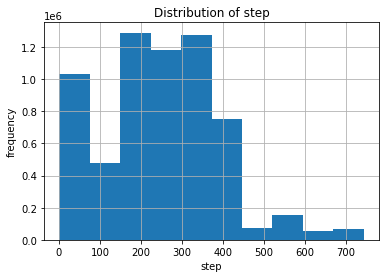

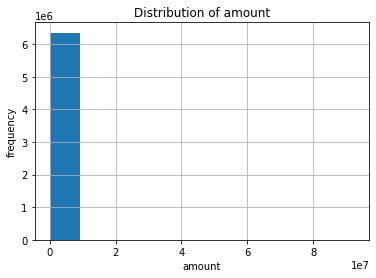

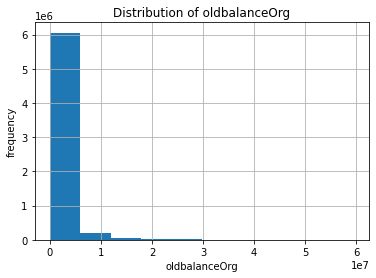

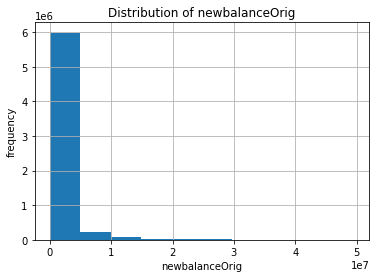

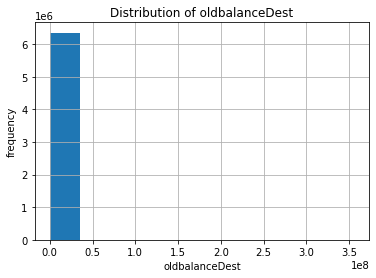

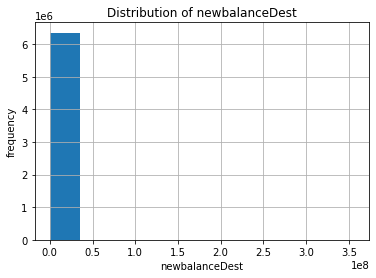

In [13]:
# Plot the histogram for all numerical variables to show their distributions
# Define a function that plots histogram

def histogram_plotter(x):
    '''
    A function that plots histogram:
    Argument(x): The numerical column to be plotted
    Parameter: df is the loaded dataframe
    Operation: Uses the matplotlib's hist() function to plot the histogram
    Returns the plot with plt.show()
    '''
    plot = df[x].hist();
    plt.title(f'Distribution of {x}')
    plt.xlabel(x)
    plt.ylabel('frequency')
    plt.show()
    

# Create a list of the numerical columns
numerical_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Use a for loop to iterate over the numerical_columns list and plot the histograms using histogram_plotter
for column in numerical_columns:
    histogram_plotter(column)

In [32]:
# Check the number of unique values for the 'nameOrig' and 'nameDest' columns
# See if it is possible to group the names for analysis

print(df['nameOrig'].nunique())
print(df['nameDest'].nunique())

6353307
2722362


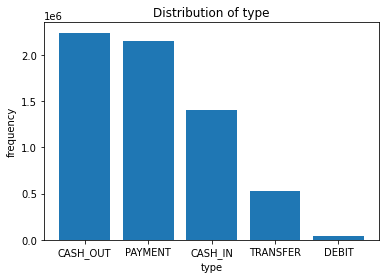

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000023533841700> (for post_execute):


KeyboardInterrupt: 

In [30]:
# Do value_counts for the categorical variable: 'type' and plot bar chart to show its distribution
# Define a function that plots bar chart

def bar_plotter(z):
    '''
    A function that plots bar chart:
    Argument(z): The categorical column to be plotted
    Parameter: df is the loaded dataframe
    Operation: Uses the matplotlib's bar() function to plot the bar chart
    Returns the plot with plt.show()
    '''
    x = df[z].value_counts().index
    y = df[z].value_counts().values
    plot = plt.bar(x,y);
    plt.title(f'Distribution of {z}')
    plt.xlabel(z)
    plt.ylabel('frequency')
    plt.show()
    
# Plot the bar chart using bar_plotter
bar_plotter('type')

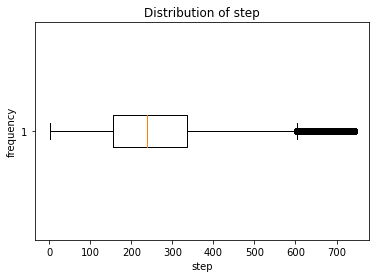

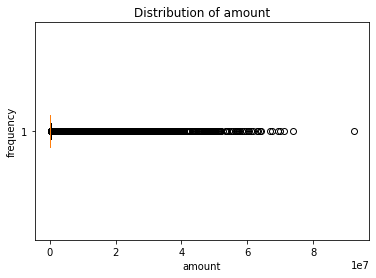

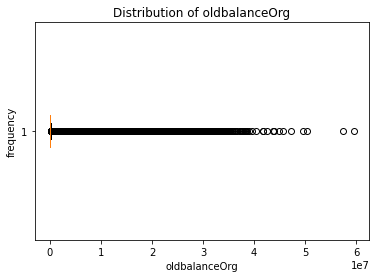

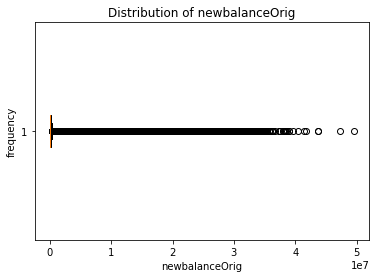

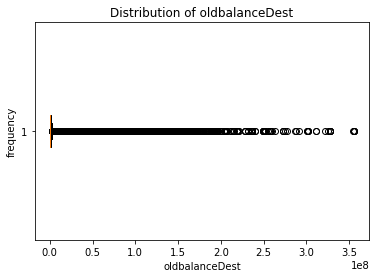

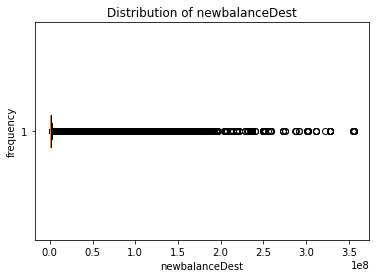

In [26]:
# Plot the boxplots for all numerical variables to show their distributions
# Define a function that plots boxplot

def boxplot_plotter(x):
    '''
    A function that plots boxplot:
    Argument(x): The numerical column to be plotted
    Parameter: df is the loaded dataframe
    Operation: Uses the matplotlib's boxplot() function to plot boxplot
    Returns the plot with plt.show()
    '''
    plot = plt.boxplot(df[x], vert=False, showfliers=True);
    plt.title(f'Distribution of {x}')
    plt.xlabel(x)
    plt.ylabel('frequency')
    plt.show()
    
# Use a for loop to iterate over the numerical_columns list already defined above
# Plot the boxplots using boxplot_plotter
for column in numerical_columns:
    boxplot_plotter(column)

#### Bivariate Analysis

In [6]:
# Plot boxplot to show relatinship between the categorical variable: 'type' and target variable: 'isFraud'
# Define a function2 that plots boxplot with the 'by' parameter

def boxplot_plotter_2(x):
    '''
    A function that plots boxplot with the 'by' parameter:
    Argument(x): The categorical column to be plotted
    Parameter: df is the loaded dataframe
               'isFraud' is the target variable
    Operation: Uses the matplotlib's boxplot() function to plot the boxplot
    Returns the plot with plt.show()
    '''
    groups = df.groupby(x)['isFraud'].apply(list).values
    plt.boxplot(groups, vert=False, showfliers=True);
    plt.title(f'Relationship between isFraud and {x}')
    plt.xlabel(x)
    plt.ylabel('isFraud')
    plt.show()
    
# Plot the boxplot using boxplot_plotter_2
boxplot_plotter_2('type')

TypeError: boxplot() got an unexpected keyword argument 'by'

13


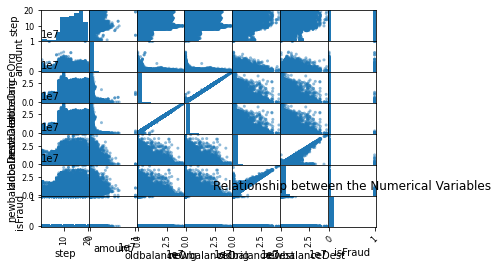

Error in callback <function flush_figures at 0x0000023533841700> (for post_execute):


KeyboardInterrupt: 

In [11]:
# Recreate a list of numerical variables with 'isFraud'
numerical_variables = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
# Create an empty list and assign it to scatter_matrices
scatter_matrices = []

# To optimize memory usage and reduce runtime
# Create df_chunk using chunksize=500000 in the pandas' read_csv function
# Also set the datatypes like before
df_chunk = pd.read_csv('Fraud.csv', chunksize=500000, 
                       dtype={'step':np.uint16, 'amount':np.float32, 'type':CategoricalDtype(), 
                              'nameOrig':str, 'oldbalanceOrg':np.float32, 'newbalanceOrig':np.float32, 
                              'nameDest':str, 'oldbalanceDest':np.float32, 'newbalanceDest':np.float32, 
                              'isFraud':np.int8, 'isFlaggedFraud':CategoricalDtype()})

# Use a for loop to iterate over the 13 chunks and plot a scatter matrix with all the numerical variables
# Append all the scatter matrices to the empty list: scatter_matrices
# Combine and plot all these matrices together
for chunk in df_chunk:
    scatter_matrix = pd.plotting.scatter_matrix(chunk[numerical_variables])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Relationship between the Numerical Variables')
    scatter_matrices.append(scatter_matrix)
    
print(len(scatter_matrices))

 ### Feature Selection

#### Correlation matrix

In [3]:
# Calculate Pearson correlation coefficients between all pairs of columns

corr_matrix = df.corr(method='pearson')
    
print(corr_matrix)

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.022373      -0.010058       -0.010299   
amount          0.022373  1.000000      -0.002762       -0.007861   
oldbalanceOrg  -0.010058 -0.002762       1.000000        0.998803   
newbalanceOrig -0.010299 -0.007861       0.998803        1.000000   
oldbalanceDest  0.027665  0.294137       0.066243        0.067812   
newbalanceDest  0.025888  0.459304       0.042029        0.041837   
isFraud         0.031578  0.076688       0.010154       -0.008148   
isFlaggedFraud  0.003277  0.012295       0.003835        0.003776   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
step                  0.027665        0.025888  0.031578        0.003277  
amount                0.294137        0.459304  0.076688        0.012295  
oldbalanceOrg         0.066243        0.042029  0.010154        0.003835  
newbalanceOrig        0.067812        0.041837 -0.008148        0.003776  
old

The correlation matrix shows the pairwise correlations between the variables in the dataset. The values range from -1 to 1, with 1 indicating a perfect positive correlation, 0 indicating no correlation, and -1 indicating a perfect negative correlation. The diagonal of the matrix shows the correlation of each variable with itself, which is always 1.

 - There is a positive correlation between "amount" and "oldbalanceDest" (0.294) as well as "newbalanceDest" (0.459), indicating that as the amount of money transferred increases, so does the balance in the destination account.

 - There is also a weak positive correlation between "isFraud" and "amount" (0.077), suggesting that larger transactions may be more likely to be fraudulent.
 
 - the correlation coefficient between "oldbalanceOrg" and "newbalanceOrig" is (0.999), indicating a strong positive correlation between these two variables. This makes sense since they both represent the account balance before and after a transaction.
 
 - There is a weak negative correlation between "newbalanceOrig" and "isFraud" (-0.008), suggesting that transactions where the account balance decreases may be less likely to be fraudulent.
 
 - "oldbalanceDest" and "newbalanceDest" are highly correlated (0.977), which makes sense since they both represent the account balance before and after a transaction.
 
 - There is a weak positive correlation between "isFraud" and "step" (0.032), indicating that fraudulent transactions may occur more frequently over time.

#### Variance Inflation Factors

In [5]:
# Import the necessary libraries
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define predictor variables X and response variable y

X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']]
y = df['isFraud']

# Fit multiple regression model with intercept

model = sm.OLS(y, sm.add_constant(X)).fit()

# Calculate variance inflation factors (VIF)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Predictor"] = X.columns

# Print VIF values

print(vif)

   VIF Factor       Predictor
0    1.188504            step
1    4.013335          amount
2  465.057591   oldbalanceOrg
3  466.879846  newbalanceOrig
4   71.789825  oldbalanceDest
5   83.262528  newbalanceDest
6    1.000574  isFlaggedFraud


Variance Inflation Factor (VIF) is a statistical measure used to quantify multicollinearity in regression analysis. In general, VIF values greater than 5 indicate a high degree of multicollinearity and may suggest that some variables should be removed from the model.

 - We can see that there is high multicollinearity between "oldbalanceOrg" and "newbalanceOrig" as well as "oldbalanceDest" and "newbalanceDest", with VIF values of **465.06**, **466.88**, **71.79**, and **83.26**, respectively. This indicates that these variables may be highly redundant and could be removed from the model to improve its performance.

 - The other predictors, "step", "amount", and "isFlaggedFraud", have VIF values less than 5, which suggests that they are not highly correlated with the other predictors and can be retained in the model.

#### Data Cleaning: Data Quality Issues

i. Missing values: missing values in the oldbalanceDest and newbalanceDest columns
 
 - It was stated that there is no information for customers starting with M (Merchants). Although there are some customers starting with C that still have missing information. Dropping these rows is not a good idea because we could miss relevant patterns. Also, replacing the zeroes with the columns means would greatly affect the accuracy of our model. Furthermore, the total of these rows is about 2.5 million. Dropping them means dropping a large chunk of the dataset, which would reduce the performance of our model. Hence, I will be retaining these rows without any alterations.

ii. Missing values: zero amount for 16 rows. All these entries were reported fraudulent

 - All the 16 entries with zero amount were reported fraudulent. This indicates a pattern in the dataset. Also, it clearly indicates missing data, since it is not possible to transact zero amount. Dropping these rows is not a good idea because we could miss relevant patterns. Also, replacing the zeroes with the columns means would greatly affect the accuracy of our model. Hence, I will be retaining these rows without any alterations.

iii. Outliers: outliers in some columns

 - Outliers in this analysis are strong predictors of fraud. Removing them would mean reducing the sensitivity of our model. Hence, I will be retaining them without any alterations.

iv. Multicolinearity: multicolinearity between "oldbalanceOrg" and "newbalanceOrig", "oldbalanceDest" and "newbalanceDest"

 - Multicollinearity can cause several problems like reduced model stability, increased standard errors, inflated p-values, and biased coefficients. There is high multicollinearity between "oldbalanceOrg" and "newbalanceOrig" as well as "oldbalanceDest" and "newbalanceDest." Since "newbalanceOrig" and "newbalanceDest" have very low correlation coefficients with the target variable, I will remove them. I will retain "oldbalanceOrg" and "oldbalanceDest."

**Predictor Variables: What are the key factors that predict fraudulent customers?**

1. Step: Positive correlation coeeficient **0.031578** of with the target variable. Highest variability was observerd in its distribution.
2. Type: The type of transaction can be an important indicator of whether it is fraudulent or not. For example, cash-out or transfer transactions may be more likely to be fraudulent compared to payment transactions.
3. Amount: Highest positive correlation coeeficient of **0.076688** with the target variable. Large transaction amounts may be more likely to be fraudulent, especially if they are much larger than the typical transaction amount.
4. Name Origins: If there are multiple transactions involving the same account or similar names, it may be an indicator of fraudulent activity.
5. Name Destinations: If there are multiple transactions involving the same account or similar names, it may be an indicator of fraudulent activity.
6. Old Balance Origins: Positive correlation coeeficient of **0.010154** with the target variable. If there is a sudden large transfer of funds from an account with a low balance, it may be an indicator of fraudulent activity.
7. Old Balance Destinations: Negative correlation coeeficient of **-0.005885** with the target variable. If there is a sudden large transfer of funds from an account with a low balance, it may be an indicator of fraudulent activity.

**Note:** Removing 'isFlaggedFraud' increased the accuracy of our model slightly. We obtained higher accuracy with less predictor variables. It also reduced the model's training time. This makes sense since it is providing no new pattern to the dataset. The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction. Moreover, this is already reflected in the amount variable. Hence, we avoid repitition.

Like 'oldbalanceOrg' and 'oldbalanceDest', "newbalanceOrig" and "newbalanceDest" make sense to predict fraudulent transactions. If there is a sudden large transfer of funds from an account with a low balance, it may be an indicator of fraudulent activity. But to remove colinearity, I will remove them ("newbalanceOrig" and "newbalanceDest") -- Since they even have very low correlation coefficients with the target variable. 

### Preprocessing

In [3]:
# Create a list of predictor variables and target variable

all_variables = ['step', 'type', 'amount', 'nameOrig', 'nameDest', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud'] 

cleaned_df = df[all_variables]
# Save the cleaned dataframe to a CSV file
cleaned_df.to_csv('cleaned_df.csv', index=False)

# Make a copy of the cleaned dataframe to be used for model building
cleaned_df_copy = cleaned_df.copy()

In [4]:
# Use pd.get_dummies() to encode the categorical variable 'type'
# Created the dummy variables in a copy of cleaned_df_copy
type_encoded_df = pd.get_dummies(cleaned_df_copy['type']).copy()

# Drop the original categorical column
cleaned_df_copy.drop(['type'], axis=1, inplace=True)

# Concatenate the encoded categorical variable with the cleaned dataframe
cleaned_df_copy = pd.concat([cleaned_df_copy, type_encoded_df], axis=1)

In [5]:
# Use LabelEncoder to encode the 'nameOrig' and 'nameDest' columns
# Import LabelEncoder module
from sklearn.preprocessing import LabelEncoder

# Create a list of the columns to encode
cols_to_encode = ['nameOrig', 'nameDest']

# Create a LabelEncoder object
le = LabelEncoder()

# Encode the selected columns
for col in cols_to_encode:
    cleaned_df_copy[col] = le.fit_transform(cleaned_df_copy[col])

In [7]:
# Get a list of all the columns now
cleaned_df_copy.columns

Index(['step', 'amount', 'nameOrig', 'nameDest', 'oldbalanceOrg',
       'oldbalanceDest', 'isFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER'],
      dtype='object')

In [6]:
# Create a list of predictor variables and target variable

predictor_variables = ['step', 'amount', 'nameOrig', 'nameDest', 'oldbalanceOrg', 
                       'oldbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
target_variable = 'isFraud'

### Random Forest Classifier

In [8]:
# Import RandomForestClassifier and train_test_split from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into features and target
X = cleaned_df_copy.drop(target_variable, axis=1)
y = cleaned_df_copy[target_variable]

# Split data into training and testing sets
# Use 20% as test data since we have a large dataset
# Set Random State to 42 to always have similar results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier and assign it to the variable: model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

In [9]:
# Save the model to disk to avoid training it again and again
# Import joblib library
import joblib

# Save the model to the disk
joblib.dump(model, 'model.joblib')

# Load the saved model
model = joblib.load('model.joblib')

### Hyperparameters Tuning

In [7]:
# Print out the default parameters used
params = model.get_params()
print(params)

NameError: name 'model' is not defined

In [9]:
# Use GridSearchCV to search for the best parameters that can improve recall 
# Import GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Specify a grid of parameters to test
# Create a dictionary of parameters and values list
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10],
              'class_weight': ['balanced', None], 'max_features': ['sqrt', 'log2', 'auto', None]}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding recall score
print(f'Best hyperparameters are {grid_search.best_params_}')
print(f'Best Recall Score is {grid_search.best_score_}')

KeyboardInterrupt: 

## Performance Evaluation

#### Confusion Matrix

In [10]:
# Import the confusion matrix module from sklearn
from sklearn.metrics import confusion_matrix

# Create and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1270856      48]
 [    631     989]]


 - Total true negatives (TTN) is 1,270,856, which means the model correctly predicted the negative class (i.e., class 0) for 1,270,856 samples.
 - Total false positives (TFP) is 48, which means the model incorrectly predicted the positive class (i.e., class 1) for 48 samples.
 - Total false negatives (TFN) is 631, which means the model incorrectly predicted the negative class (i.e., class 0) for 631 samples.
 - Total true positives (TTP) is 989, which means the model correctly predicted the positive class (i.e., class 1) for 989 samples.
 
In fraud detection, false negatives can be more costly. They allow fraudulent transactions to go undetected and cause financial losses. False negatives of 631 could be an indication that the model needs to be improved in detecting fraudulent transactions. However, true negatives of 1,270,856 out of 1,271,534 means the dataset is biased. It has more negatives than positives.

#### Accuracy score, Precision score, Recall score, F1 score

In [11]:
# Import accuracy_score, precision_score, recall_score, and f1_score functions from sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy is {accuracy}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision is {precision}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall is {recall}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 score is {f1}')


Accuracy is 0.9994664147788175
Precision is 0.9537126325940212
Recall is 0.6104938271604938
F1 score is 0.7444486262702297


 - The accuracy of **0.9994664147788175** suggests that the model is able to correctly classify the majority of the samples. 

 - The precision of **0.9537126325940212** suggests that out of all the samples predicted as positive by the model, **95.37%** of them are actually positive. This means that the model is making a relatively low number of false positive errors, which is desirable in applications like fraud detection.
 
 - The recall of **0.6104938271604938** suggests that out of all the actual positive samples in the dataset, the model is able to correctly identify **61.05%** of them as positive. This indicates that the model may be missing some positive samples, which is not ideal in a fraud detection problem. In this case minimizing false negatives is important.

 - The F1 score of **0.7444486262702297** is the harmonic mean of precision and recall. It offers a single metric to evaluate the model's overall performance. In this case the model's performance is relatively balanced between precision and recall, but there is still room for improvement.

In summary, the model appears to have achieved a high level of accuracy and precision, but may benefit from improving its recall in order to better detect positive samples (i.e., fraudulent transactions).

#### ROC curve

AUC score is 0.9755545867691108


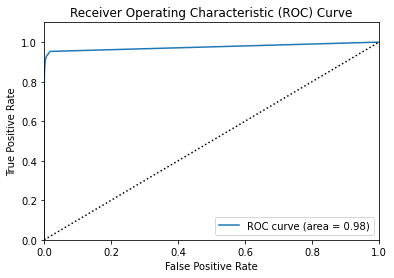

In [10]:
# Import roc_curve, roc_auc_curve functions from sklearn.metrics
from sklearn.metrics import roc_curve, roc_auc_score

# Use predict_proba method to get probability estimates for test set
y_prob = model.predict_proba(X_test)

# Calculate fpr, tpr, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob[:, 1])
print(f'AUC score is {auc_score}')

# Plot ROC curve
plt.plot(fpr, tpr, label = f"ROC curve (area = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k:')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

 - AUC score of **0.9755545867691108** suggests that the model is highly accurate in its predictions and has a strong ability to discriminate between positive and negative samples. This is a good result and suggests that the model may be effective in predicting fraudulent transactions, assuming that the underlying data is reliable and representative of the problem domain.

#### Precision-recall curve

Average Precision score is 0.8285361468606509


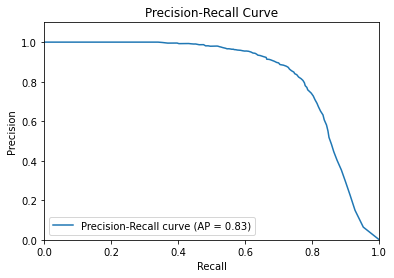

In [13]:
# Import precision_recall_curve, and average_precision_score functions from sklearn.metrics
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])

# Calculate average precision score
avp_score = average_precision_score(y_test, y_prob[:, 1])
print(f'Average Precision score is {avp_score}')

# Plot precision-recall curve
plt.plot(recall, precision, label = f"Precision-Recall curve (AP = {avp_score:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

 - An average precision score of **0.8285361468606509** indicates that the model has a moderate to high probability of correctly identifying positive examples, while minimizing the number of false positives. 1 indicates perfect classification.

 - Average precision score of **0.8285361468606509** suggests that the model is relatively accurate in its predictions and has a reasonable ability to balance precision and recall. However, there is still room for improvement.

#### Feature Importance Plot

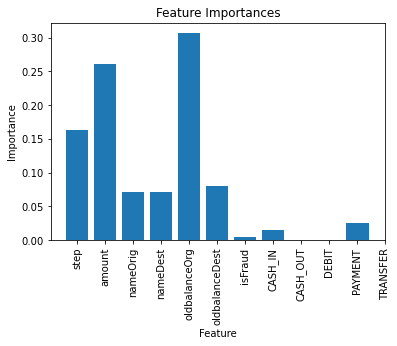

In [19]:
# Import matplotlib.ticker function from MultipleLocator
# Use the matplotlib.ticker function to ensure that the number of xticks corresponds to the number of features
# And it does not return a value error
# Use the matplotlib.ticker function to fix the features on the xticks
from matplotlib.ticker import MultipleLocator

# Plot feature importances
plt.bar(range(X.shape[1]), model.feature_importances_)
plt.xticks(range(X.shape[1]+1), cleaned_df_copy.columns, rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.title("Feature Importances")
atplt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

 - Feature importance scores range from 0 to 1. A score of 0 indicates that the feature has no importance in the model's predictions, while a score of 1 indicates that the feature has the highest importance. 
 
 - All the importance scores are less than 0.35. This suggests that the corresponding features are relatively important, but not the most important feature in the model.

#### Cross-validation

In [20]:
# Import cross_val_score function from sklearn.model_selection
from sklearn.model_selection import cross_val_score

# perform 10-fold cross-validation on the dataset
scores = cross_val_score(rfc, X, y, cv=10)

# print mean score and standard deviation
print(f'Cross-validation scores are {scores}')
print(f'Mean score is {scores.mean()}')
print(f'Standard deviation is {scores.std}')


KeyboardInterrupt: 

### Actionable Plan

1. Review data collection process to ensure important predictor features and variables are collected
2. Use the improved dataset to build more sophisticated random forest algorithm
3. Improve on this model by tuning 'class_weight' hyperparameter to 'balanced'

##### Question 1: What kind of prevention should be adopted while company update its infrastructure?

It is best the company updates its infrastructure. But in the mean time, the company can employ these fraud prevention strategies:

1. The company can employ multi-factor authentication (MFA) that would require two or more forms of authentication like secret question, fingerprint, and OTP sent to registered phone number before high risk transactions are carried out.

2. Ensure that even merchants' balances are captured as merchants can perpetrate fraudulent transactions with hidden account information.

3. The company should monitor access logs by keeping records of who accesses sensitive data and when, and review these logs regularly for any suspicious activity. This can help detect unauthorized access attempts or data breaches in real-time. And if they have the capacity now, they can use encryption to hide sensitive data to prevent unauthorized access in storage or tansit.

4. Ensure they train and scrutinize their employees well on data security and fraud prevention as missing information like zero amounts could indicate internal threats. Better still, the company should execute level-based access to data and information.

5. Conduct fraud awareness campaigns for clients

##### Question 2:  Assuming these actions have been implemented, how would you determine if they work?

In order to evaluate the success of the fraud prevention strategies implemented, the following can be done:

1. They should get fraud analysts to track flagged transactions and  assess the number and type of fraud incidents over time and compare them with previous periods.

2. The company should monitor compliance with level-based access to data and fraud prevention policies to assess if they are being followed correctly. Disciplinary actions should be taken where necessary.